In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Part A: ( 25 PTS )
    In this part, the code loads images from specified training and testing directories. Each image is read using the OpenCV library, and basic descriptors are computed to convert them into numerical feature vectors. These descriptors are crucial for machine learning tasks as they provide a quantifiable representation of the images.

    In order to find neareast neighbor, I implement euclidian distance in this part

In [ ]:
def load_dataset(dataset_path):
    data = []
    labels = []
    index = 0
    for label in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, label)
        if os.path.isfile(file_path):
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            '''
            Following two lines are mini debug purpose to check if images are loaded or not
            '''
            # plt.imshow( image, cmap='gray', aspect='equal' )
            # plt.show()

            data.append(image)
            labels.append(label.split('.')[0])
    return data, labels

In [ ]:
TRAIN_PATH = 'mpeg7shapeB/train'
TEST_PATH = 'mpeg7shapeB/test'

In [ ]:
TRAIN_DATA, TRAIN_LABELS = load_dataset( TRAIN_PATH )
TEST_DATA, TEST_LABELS = load_dataset( TEST_PATH )

In [ ]:
def compute_basic_descriptors(image):
    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Take the largest contour assuming it is the shape
    contour = max(contours, key=cv2.contourArea)

    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h
    rect_area = w * h
    extent = float(area) / rect_area
    # Hu moments
    moments = cv2.moments(contour)
    hu_moments = cv2.HuMoments(moments).flatten()

    return np.array([area, perimeter, aspect_ratio, extent, *hu_moments])

In [ ]:
TRAIN_FEATURES = [compute_basic_descriptors(image) for image in TRAIN_DATA]
TEST_FEATURES = [compute_basic_descriptors(image) for image in TEST_DATA]

In [ ]:
# Debug Purpose for Chi-Squared
print("Example feature vectors:")
for i in range(3):
    print(f"Feature vector {i + 1}: {TRAIN_FEATURES[i]}")

Example feature vectors:
Feature vector 1: [4.51325000e+04 2.53542674e+03 1.80392157e+00 3.84761296e-01
 4.15550655e-01 1.04201096e-01 3.33009310e-03 3.33931933e-03
 9.43672842e-06 6.05042263e-04 5.91190293e-06]
Feature vector 2: [ 3.96560000e+04  1.79258282e+03  9.57575758e-01  3.80283851e-01
  4.83991569e-01  4.30809031e-03  6.79996189e-03  5.80438992e-03
 -3.49841777e-05 -3.40731189e-04 -1.02896234e-05]
Feature vector 3: [1.45835000e+04 9.13428493e+02 1.75939850e+00 4.68591350e-01
 2.37679057e-01 2.07623875e-02 2.79446541e-03 1.21419389e-03
 2.21343947e-06 1.69400943e-04 3.20790611e-07]


In [ ]:
# Feature Scaling
scaler = StandardScaler()
TRAIN_FEATURES = scaler.fit_transform(TRAIN_FEATURES)
TEST_FEATURES = scaler.transform(TEST_FEATURES)

In [ ]:
def euclidean_distance(a, b):
    return distance.euclidean(a, b)

def manhattan_distance(a, b):
    return distance.cityblock(a, b)

def chi_squared_distance(a, b, epsilon = 1e-10):
    '''
    Since our vectors are not histogram-like, means contains negative numbers, to work with chi squared distance,
    it is applied an approach to work with chi-squared as well.
    '''
    return 0.5 * np.sum(((a - b) ** 2) / (np.abs(a + b) + epsilon))

# Mahalanobis distance requires a covariance matrix which you can compute from your data
cov_matrix = np.cov(np.array(TRAIN_FEATURES).T)
def mahalanobis_distance(a, b):
    # Regularize the covariance matrix to ensure it's invertible
    reg_cov_matrix = cov_matrix + 1e-10 * np.eye(cov_matrix.shape[0])
    inv_cov_matrix = np.linalg.inv(reg_cov_matrix)
    return distance.mahalanobis(a, b, inv_cov_matrix)

In [ ]:
def find_nearest_neighbor(TEST_FEATURE, TRAIN_FEATURE):
    dist = np.array([euclidean_distance(TEST_FEATURE, TRAIN_F) for TRAIN_F in TRAIN_FEATURE])
    return np.argmin( dist )

In [ ]:
nearest_neighbors_indices = [find_nearest_neighbor(test_feature, TRAIN_FEATURES) for test_feature in TEST_FEATURES]
nearest_neighbors_labels = [TRAIN_LABELS[index] for index in nearest_neighbors_indices]

In [ ]:
def classify(test_features, train_features, train_labels):
    predicted_labels = []

    for test_feature in test_features:
        nearest_index = find_nearest_neighbor(test_feature, train_features)
        predicted_labels.append(train_labels[nearest_index])

    return predicted_labels

In [ ]:
def display_image(true, true_data, nearest_indices, test_data,  predicted, idx):
    '''Display the images'''
    plt.figure(figsize=(8, 2))

    # Display true image
    plt.subplot(1, 2, 1)
    plt.imshow(true_data[idx], cmap='gray')
    plt.title(f'True: {true}')
    plt.axis('off')

    # Find and display the predicted image
    predicted_idx = nearest_indices[idx]
    plt.subplot(1, 2, 2)
    plt.imshow(test_data[predicted_idx], cmap='gray')
    plt.title(f'Predicted: {predicted}')
    plt.axis('off')

    plt.show()

In [ ]:
def calculate_accuracy(true_labels, predicted_labels, true_data, test_data,nearest_indices, num_of_images = 2, distance_func = 'EUCLIDIAN'):
    correct = 0
    print( f'{distance_func} DISTANCE')
    for idx, (true, predicted) in enumerate( zip(true_labels, predicted_labels) ):
        true = true.split('-')[0]
        predicted = predicted.split('-')[0]
        if true == predicted:
            correct += 1
        if idx < num_of_images:
            display_image(true, true_data, nearest_indices, test_data,  predicted, idx )
    return correct / len(true_labels)

EUCLIDIAN DISTANCE


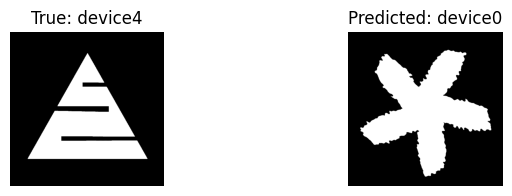

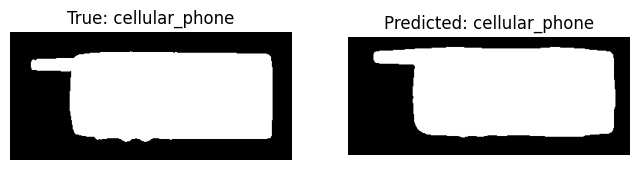

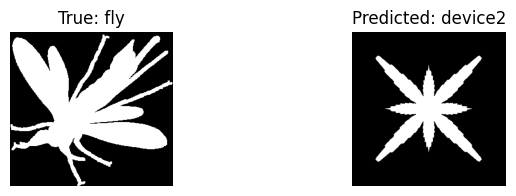

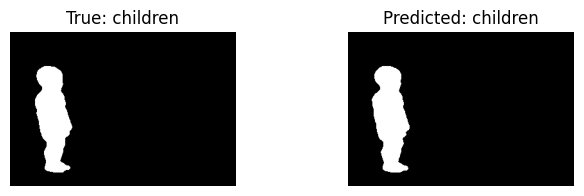

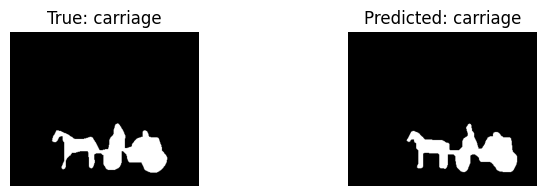

Accuracy of Euclidian Distance classification: 66.29%


In [ ]:
predicted_test_labels = classify(TEST_FEATURES, TRAIN_FEATURES, TRAIN_LABELS)
test_accuracy = calculate_accuracy(TEST_LABELS, predicted_test_labels, TEST_DATA, TRAIN_DATA, nearest_neighbors_indices)

print(f'Accuracy of Euclidian Distance classification: {test_accuracy:.2%}')

# Part B: ( 25 PTS )
    This section implements various distance functions used to find the nearest neighbors. These functions are critical in pattern recognition and classification tasks where the similarity between feature vectors needs to be calculated.
    Below it is listed that functions:
    1 - Manhattan
    2 - Chi-Squared
    3 - Mahalanobis

In [ ]:
def find_nearest_neighbor_with_function(TEST_FEATURE, TRAIN_FEATURE, distance_func):
    dist = np.array([distance_func(TEST_FEATURE, TRAIN_F) for TRAIN_F in TRAIN_FEATURE])
    return np.argmin(dist)


In [ ]:
def classify_with_functions(test_features, train_features, train_labels, distance_func):
    predicted_labels = []

    for test_feature in test_features:
        nearest_index = find_nearest_neighbor_with_function(test_feature, train_features, distance_func)
        predicted_labels.append(train_labels[nearest_index])

    return predicted_labels


In [ ]:
def run_experiment(distance_func, distance_func_name):
    # Recalculate nearest neighbors indices with the current distance function
    nearest_indices = [find_nearest_neighbor_with_function(test_feature, TRAIN_FEATURES, distance_func) for test_feature in TEST_FEATURES]

    predicted_test_labels = classify_with_functions(TEST_FEATURES, TRAIN_FEATURES, TRAIN_LABELS, distance_func)
    test_accuracy = calculate_accuracy(TEST_LABELS, predicted_test_labels, TEST_DATA, TRAIN_DATA, nearest_indices, 10, distance_func_name.upper())
    print(f'Accuracy with {distance_func_name}: {test_accuracy:.2%}\n')

    return test_accuracy

MANHATTAN DISTANCE


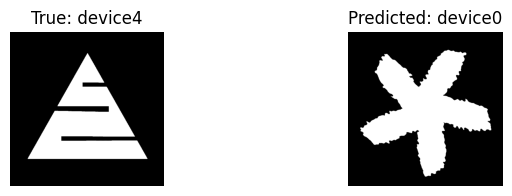

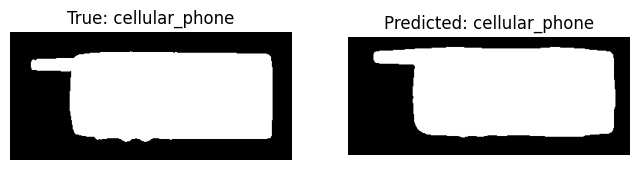

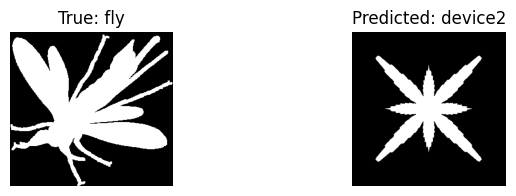

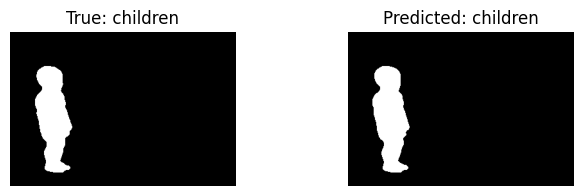

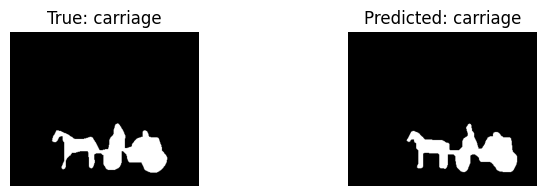

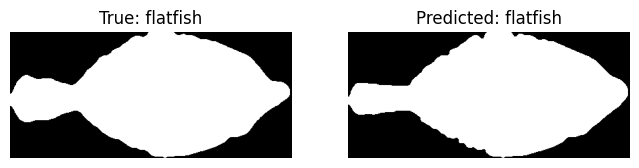

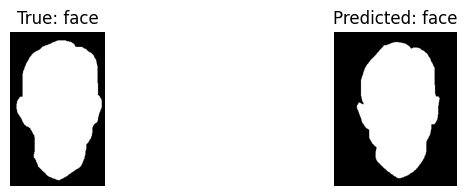

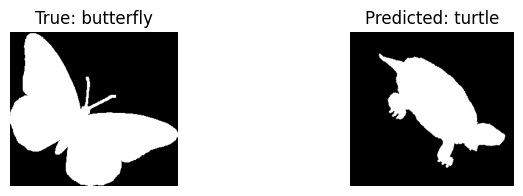

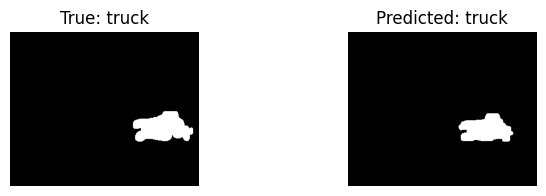

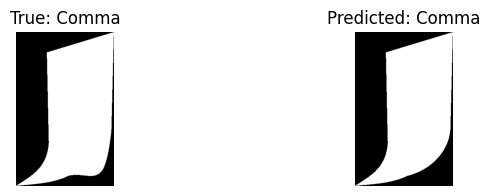

Accuracy with Manhattan: 70.43%



In [ ]:
manhattan = run_experiment(manhattan_distance, "Manhattan")

CHI-SQUARED DISTANCE


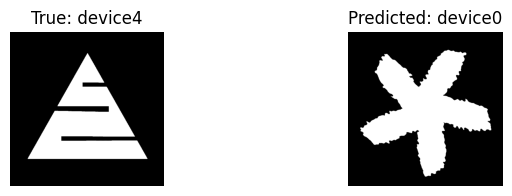

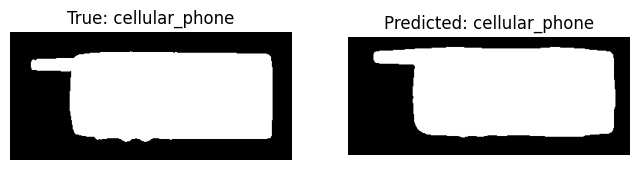

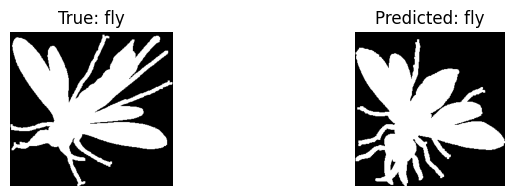

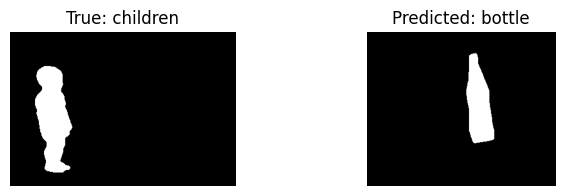

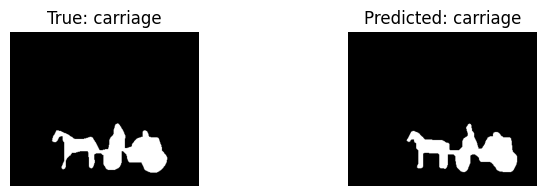

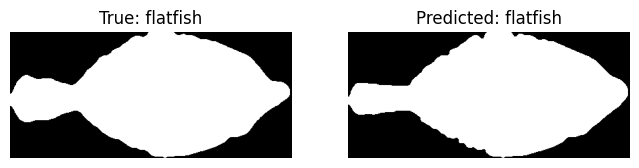

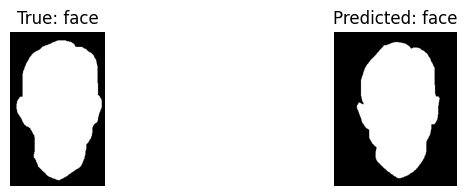

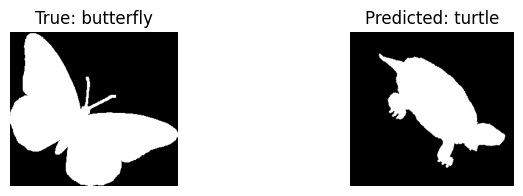

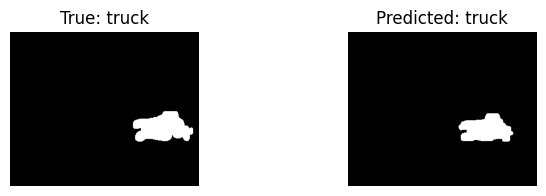

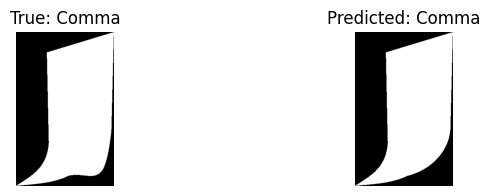

Accuracy with Chi-squared: 66.86%



0.6685714285714286

In [ ]:
chi_squared = run_experiment(chi_squared_distance, "Chi-squared")

MAHALANOBIS DISTANCE


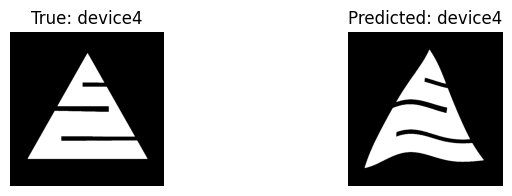

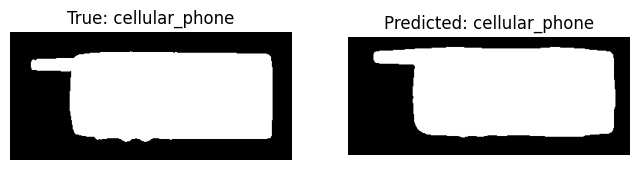

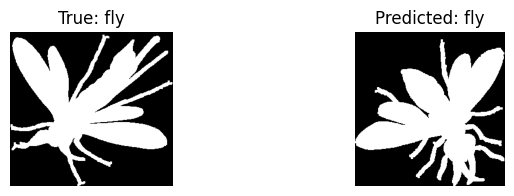

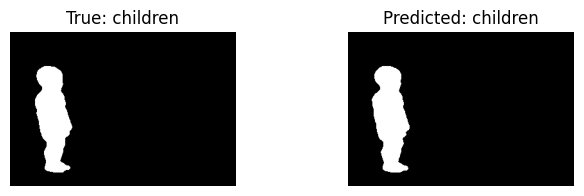

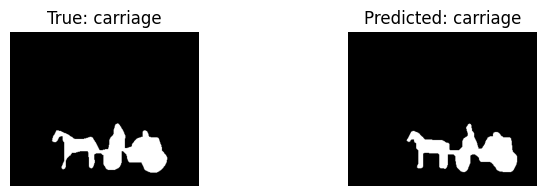

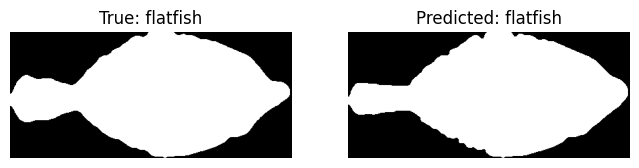

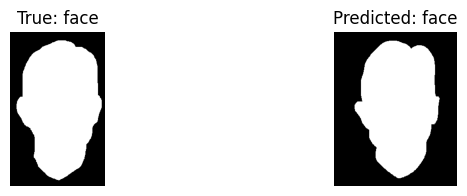

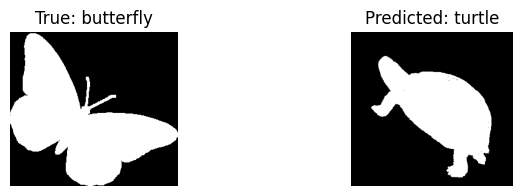

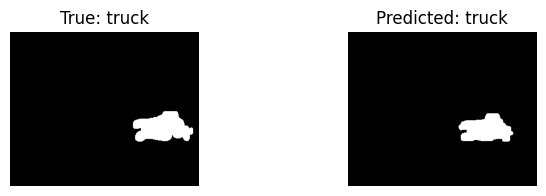

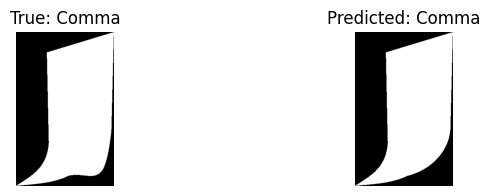

Accuracy with Mahalanobis: 71.29%



0.7128571428571429

In [ ]:
mahalanobis = run_experiment(mahalanobis_distance, "Mahalanobis")

# 2nd Part ( 50 PTS ):

- The following code calculates the Fourier descriptors and additional shape descriptors for the images. Fourier descriptors are used to capture the shape of an object in the image, while the additional descriptors provide further details like convexity, circularity, rectangularity, and eccentricity. Varying numbers of Fourier coefficients are tested to observe their impact on classification accuracy.

In [ ]:
def compute_fourier_descriptors(contour, num_coefficients=5):
    # Fourier Descriptors
    contour = contour.squeeze()

    if contour.shape[0] == 0:
        return np.zeros(num_coefficients)

    complex_contour = np.empty(contour.shape[:-1], dtype=complex)

    complex_contour.real = contour[:, 0]
    complex_contour.imag = contour[:, 1]

    fourier_result = np.fft.fft(complex_contour)
    # Ensure a fixed number of coefficients
    descriptors = np.abs(fourier_result[:num_coefficients])
    if len(descriptors) < num_coefficients:
        # Pad with zeros if necessary
        descriptors = np.pad(descriptors, (0, num_coefficients - len(descriptors)), 'constant')

    return descriptors / descriptors[0]  # Normalize

- By dividing the shape into regions and counting the number of pixels in each region, I am going to compute histogram shape.

In [ ]:
def compute_shape_histogram(image, num_bins=10):
    hist, _ = np.histogram(image, bins=num_bins, range=[0, 256])
    return hist

- Implementing additional descriptors like convexity, circularity, rectangularity, and eccentricity:

In [ ]:
def compute_additional_descriptors(contour):
    # Convexity
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    contour_area = cv2.contourArea(contour)
    convexity = hull_area / contour_area if contour_area != 0 else 0

    # Circularity
    perimeter = cv2.arcLength(contour, True)
    circularity = 4 * np.pi * contour_area / (perimeter * perimeter) if perimeter != 0 else 0

    # Rectangularity and Eccentricity
    if len(contour) >= 5:
        _, (MA, ma), angle = cv2.fitEllipse(contour)
        rectangularity = contour_area / (MA * ma * np.pi) if MA != 0 and ma != 0 else 0
        eccentricity = np.sqrt(1 - (MA / ma)**2) if ma != 0 else 0
    else:
        rectangularity = 0
        eccentricity = 0

    return np.array([convexity, circularity, rectangularity, eccentricity])



In [ ]:
def compute_hu_moments(contour):
    moments = cv2.moments(contour)
    hu_moments = cv2.HuMoments(moments).flatten()
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    return hu_moments


In [ ]:
def compute_combined_features(image, num_coeff_fourier = 5):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return np.zeros(20)  # Adjust the size according to the number of features
    contour = max(contours, key=cv2.contourArea)

    fourier_descriptors = compute_fourier_descriptors(contour, num_coeff_fourier)
    shape_histogram = compute_shape_histogram(image)
    additional_descriptors = compute_additional_descriptors(contour)
    hu_moments = compute_hu_moments(contour)

    combined_features = np.concatenate([fourier_descriptors, shape_histogram, additional_descriptors, hu_moments])

    # Ensure that combined_features is of fixed length
    expected_length = num_coeff_fourier + 10 + 4 + 7  # adjust this based on your feature lengths
    if len(combined_features) != expected_length:
        raise ValueError(f"Combined features length mismatch: {len(combined_features)} expected {expected_length}")

    return combined_features


In [ ]:
def run_experiments_for_fourier_coefficients(num_coefficients: int) -> dict:
    # Recompute features with the specified number of Fourier coefficients
    global TRAIN_FEATURES, TEST_FEATURES
    TRAIN_FEATURES = [compute_combined_features(image, num_coefficients) for image in TRAIN_DATA]
    TEST_FEATURES = [compute_combined_features(image, num_coefficients) for image in TEST_DATA]

    # Feature Scaling
    scaler = StandardScaler()
    TRAIN_FEATURES = scaler.fit_transform(TRAIN_FEATURES)
    TEST_FEATURES = scaler.transform(TEST_FEATURES)

    # Recompute the covariance matrix
    TRAIN_MANHATTAN = TRAIN_FEATURES.copy()
    global cov_matrix
    cov_matrix = np.cov(np.array(TRAIN_MANHATTAN).T)

    accuracies = {num_coefficients: {} }
    # Run experiments with each distance function
    print(f"Experiments with {num_coefficients} Fourier coefficients:")
    accuracies[num_coefficients]['Euclidean'] = run_experiment(euclidean_distance, "Euclidean")
    accuracies[num_coefficients]['Manhattan'] = run_experiment(manhattan_distance, "Manhattan")
    accuracies[num_coefficients]['Chi-squared'] = run_experiment(chi_squared_distance, "Chi-squared")
    accuracies[num_coefficients]['Mahalanobis'] = run_experiment(mahalanobis_distance, "Mahalanobis")
    print("\n")

    return accuracies

Experiments with 3 Fourier coefficients:
EUCLIDEAN DISTANCE


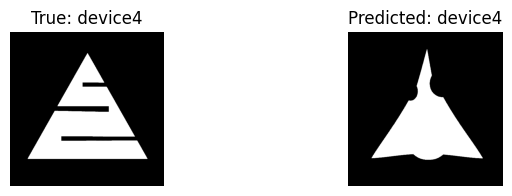

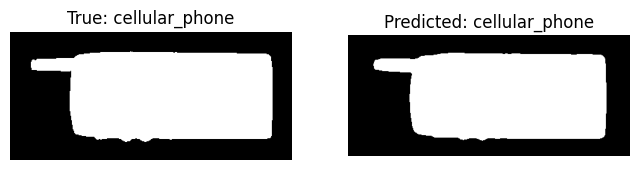

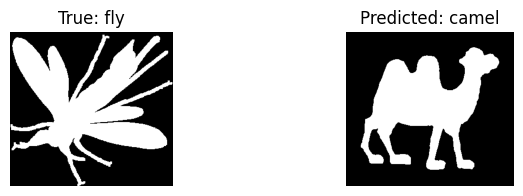

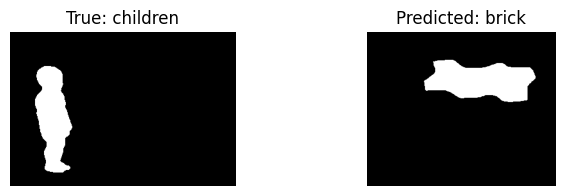

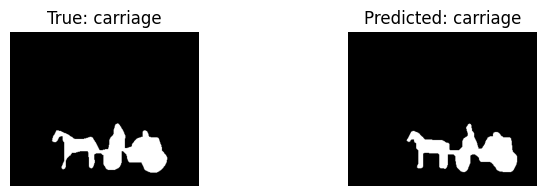

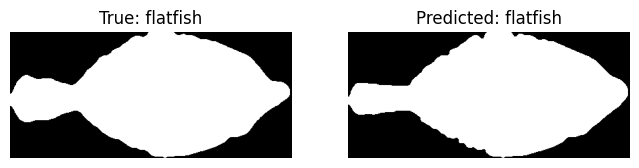

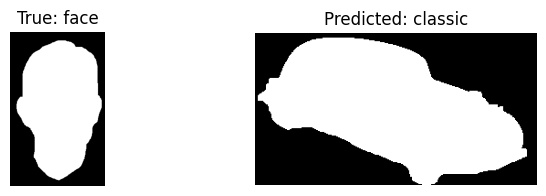

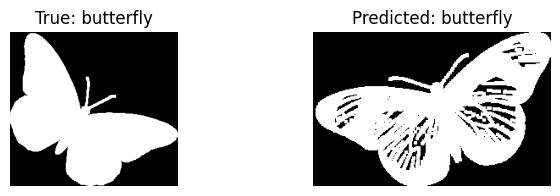

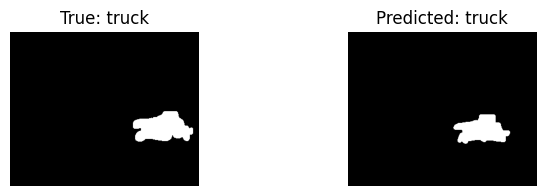

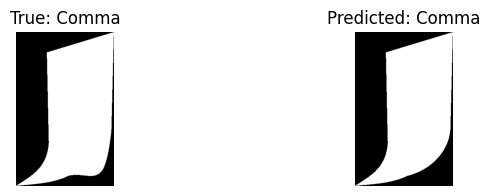

Accuracy with Euclidean: 65.00%

MANHATTAN DISTANCE


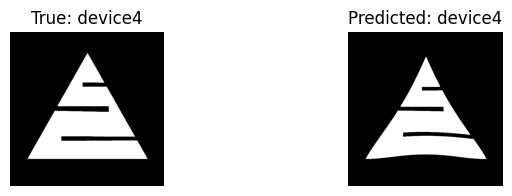

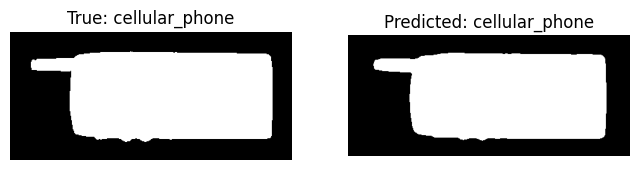

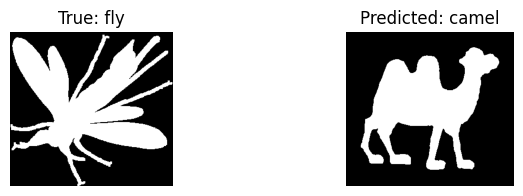

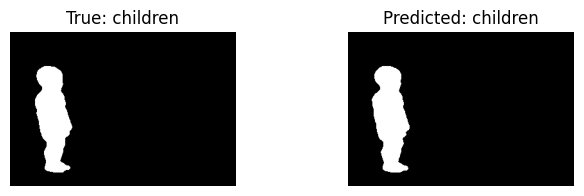

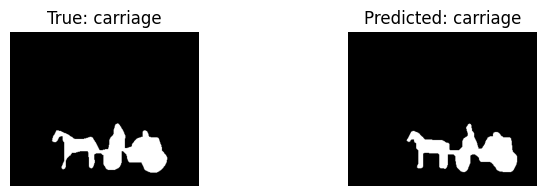

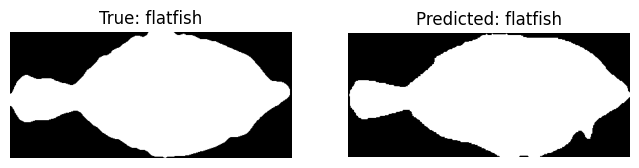

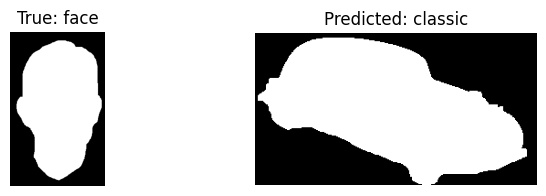

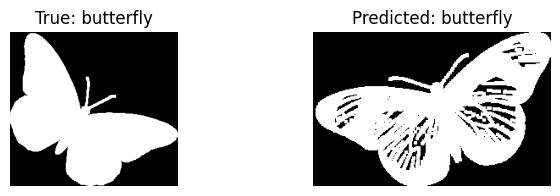

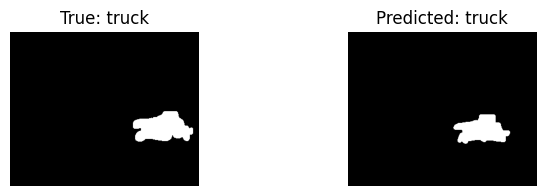

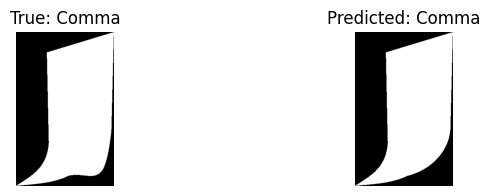

Accuracy with Manhattan: 74.86%

CHI-SQUARED DISTANCE


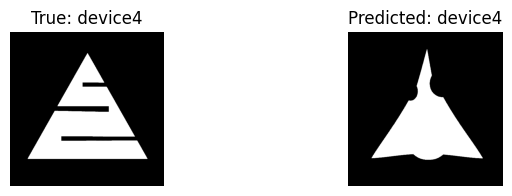

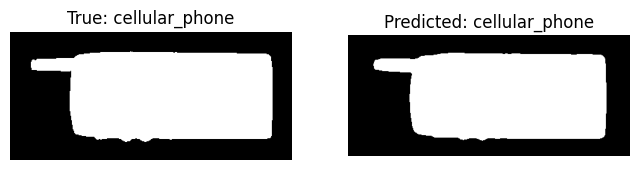

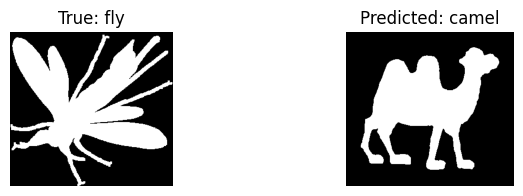

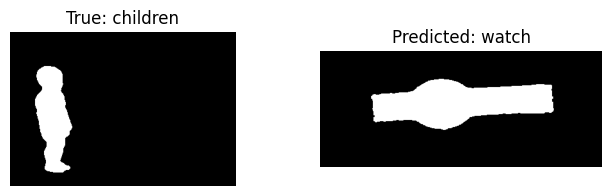

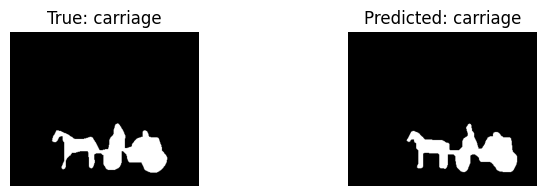

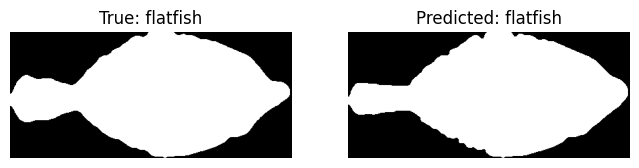

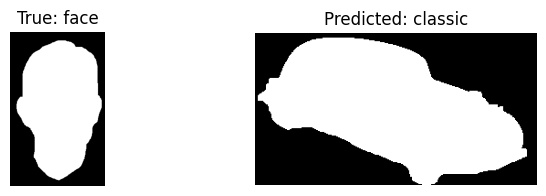

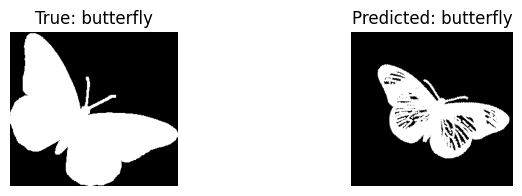

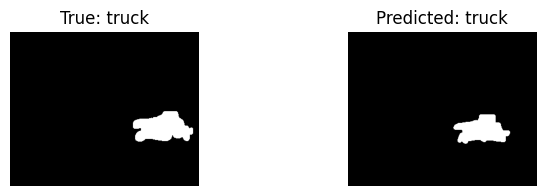

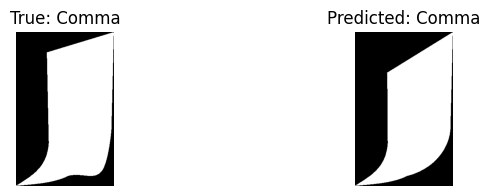

Accuracy with Chi-squared: 60.14%

MAHALANOBIS DISTANCE


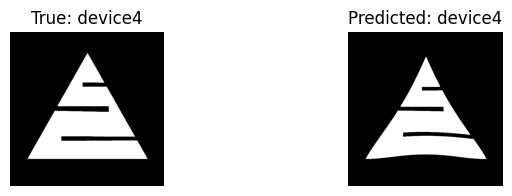

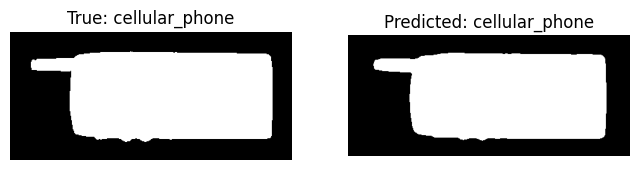

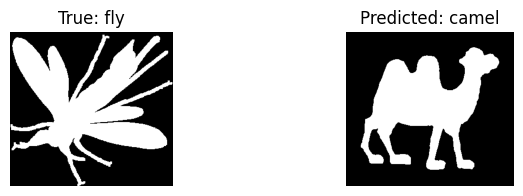

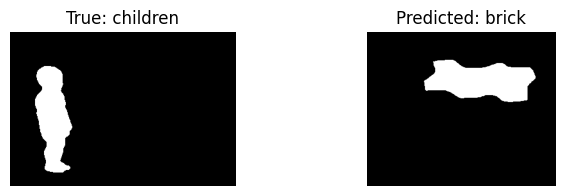

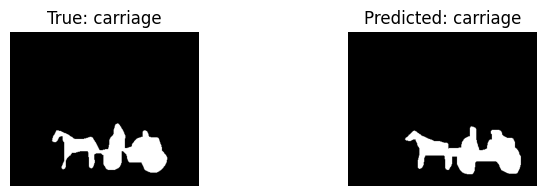

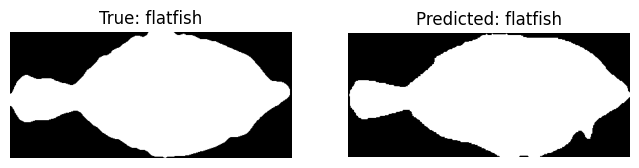

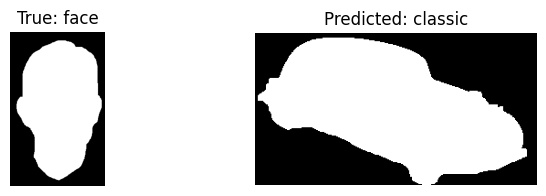

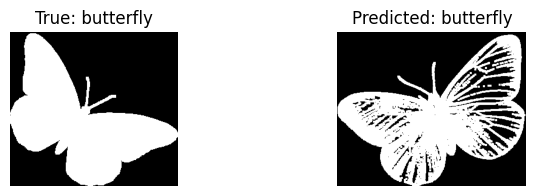

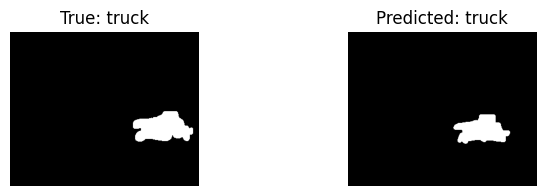

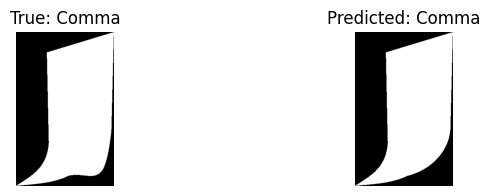

Accuracy with Mahalanobis: 68.43%





In [ ]:
accuracy_with_coefficient3 = run_experiments_for_fourier_coefficients(3)

Experiments with 5 Fourier coefficients:
EUCLIDEAN DISTANCE


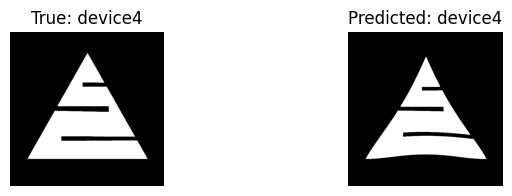

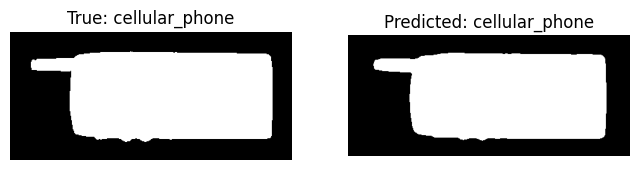

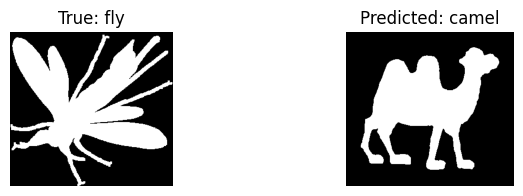

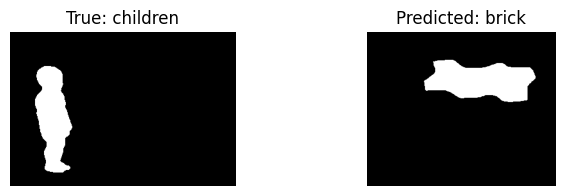

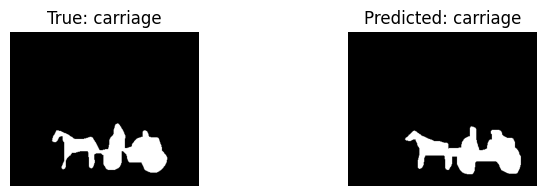

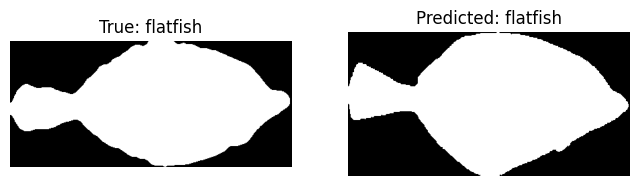

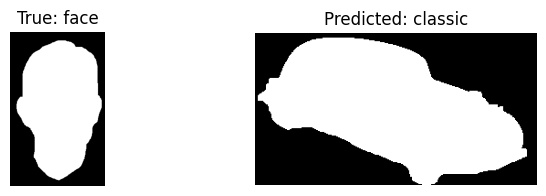

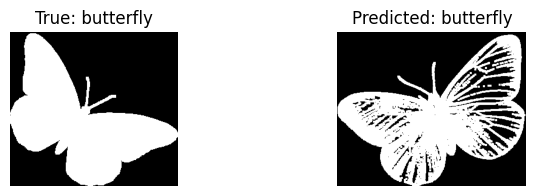

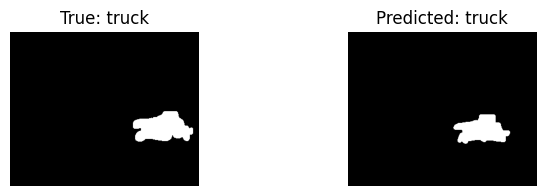

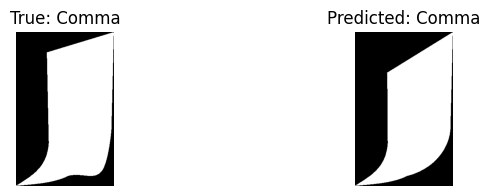

Accuracy with Euclidean: 67.14%

MANHATTAN DISTANCE


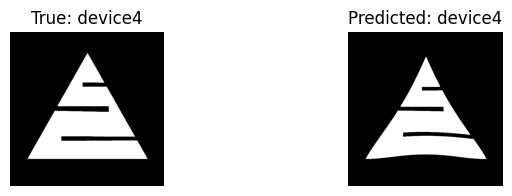

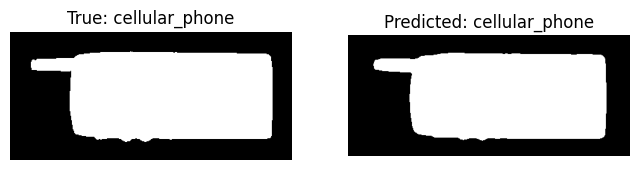

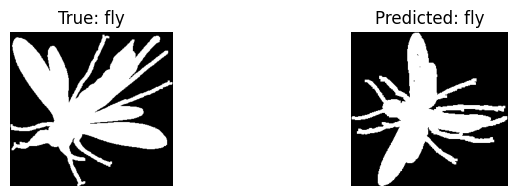

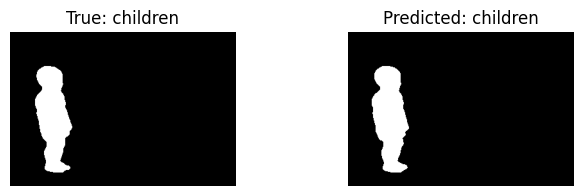

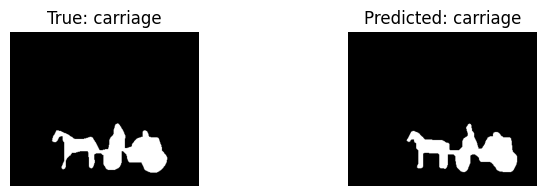

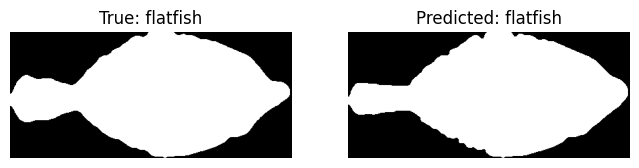

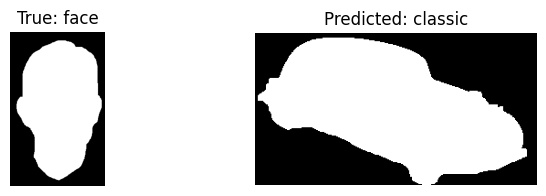

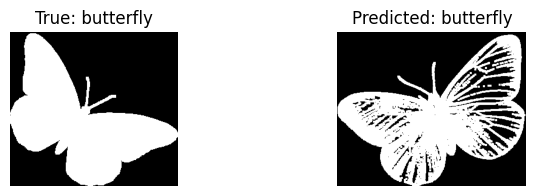

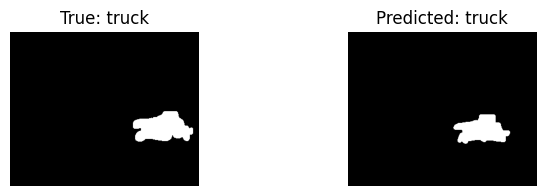

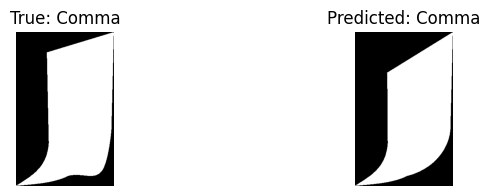

Accuracy with Manhattan: 77.14%

CHI-SQUARED DISTANCE


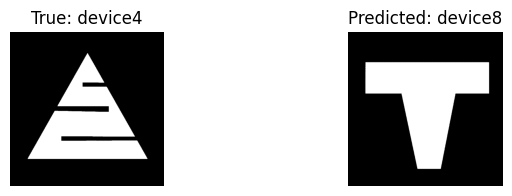

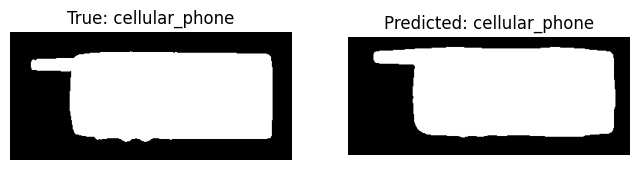

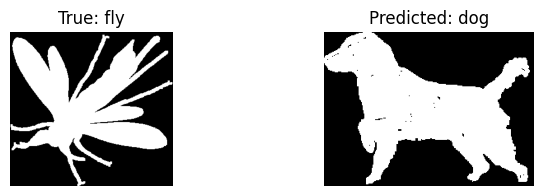

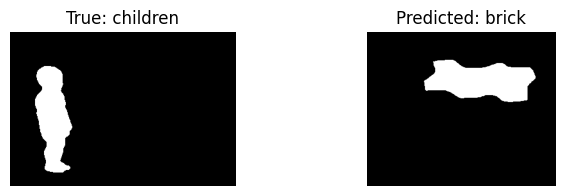

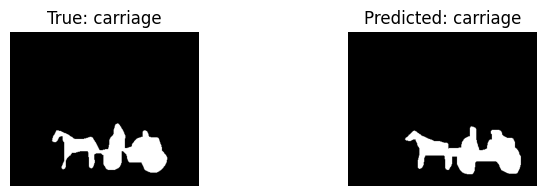

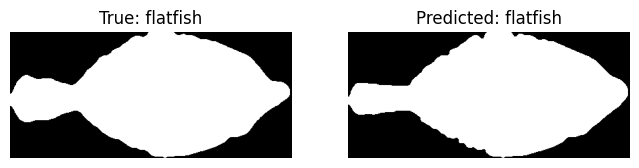

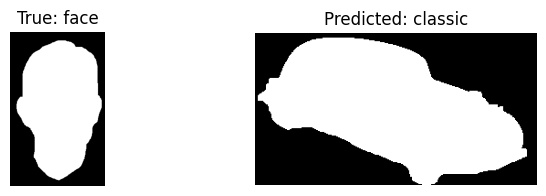

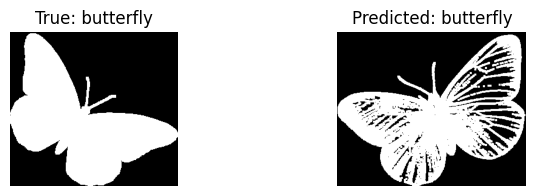

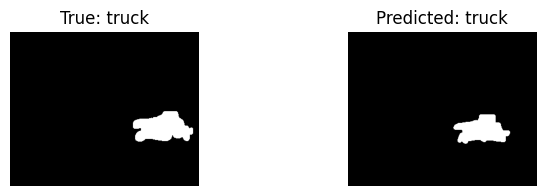

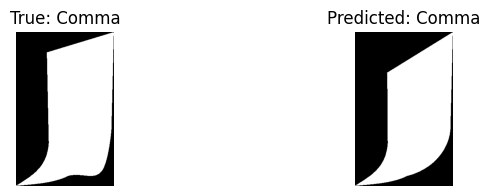

Accuracy with Chi-squared: 62.00%

MAHALANOBIS DISTANCE


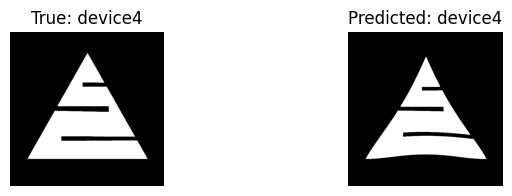

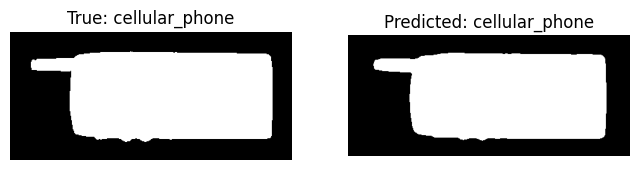

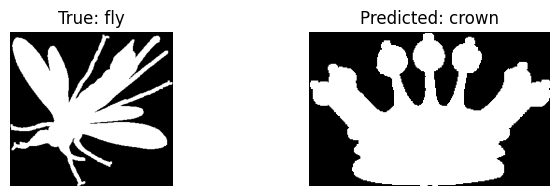

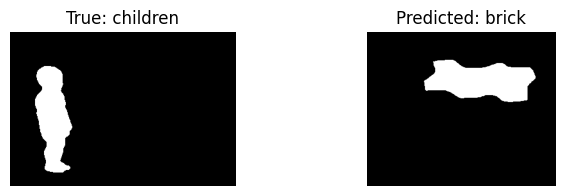

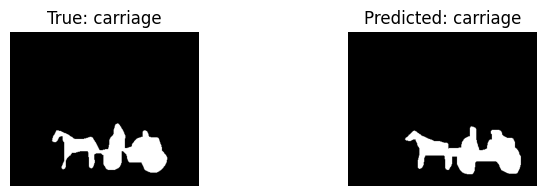

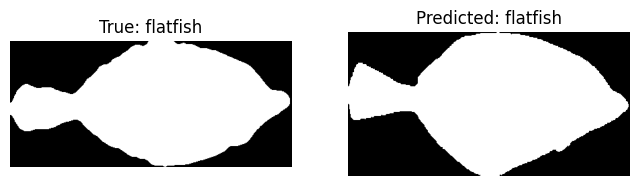

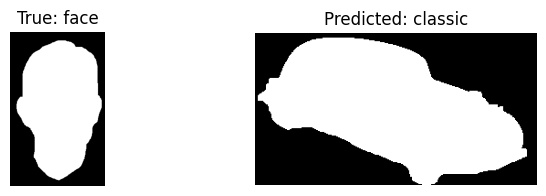

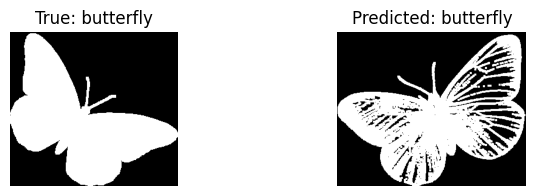

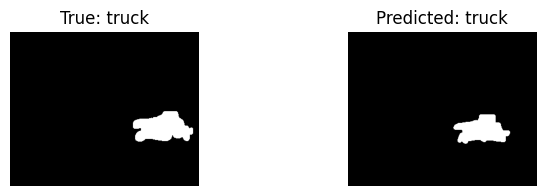

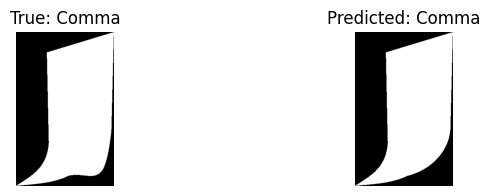

Accuracy with Mahalanobis: 71.29%





In [ ]:
accuracy_with_coefficient5 = run_experiments_for_fourier_coefficients(5)

Experiments with 7 Fourier coefficients:
EUCLIDEAN DISTANCE


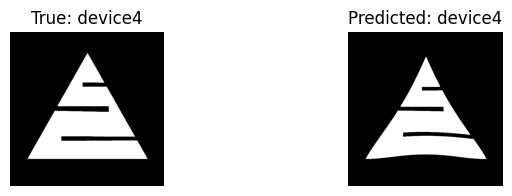

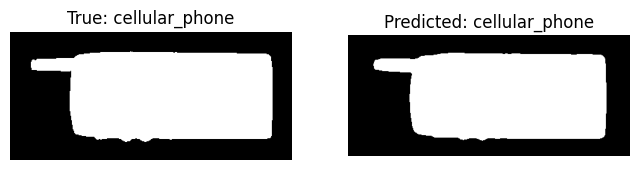

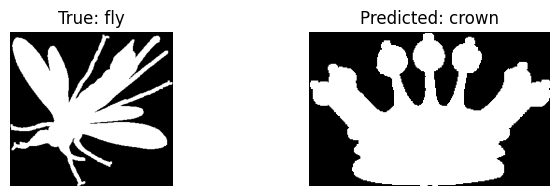

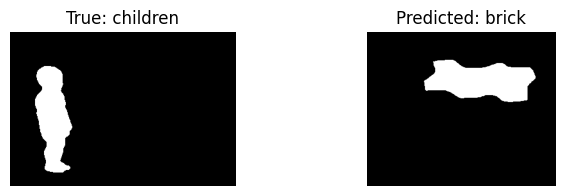

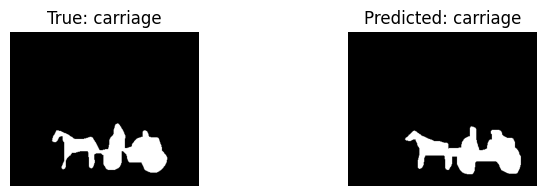

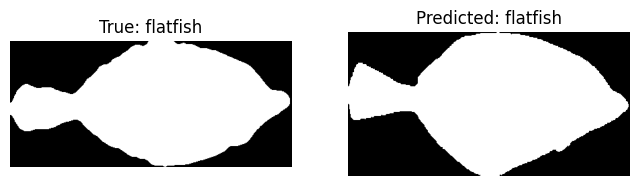

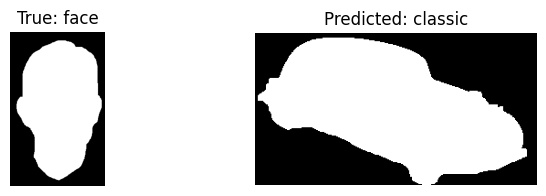

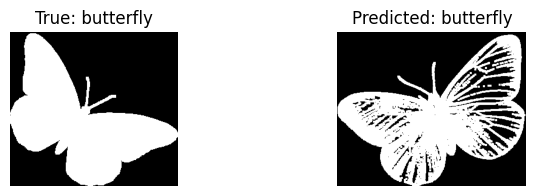

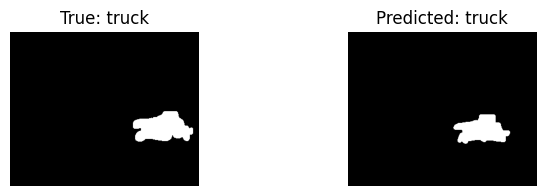

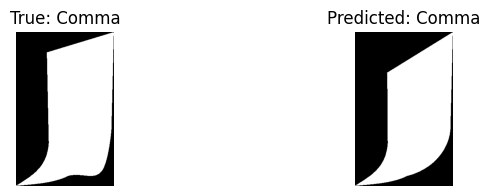

Accuracy with Euclidean: 69.29%

MANHATTAN DISTANCE


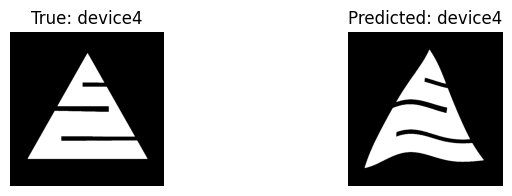

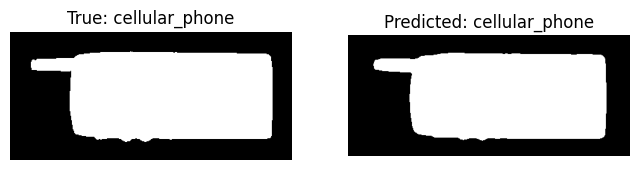

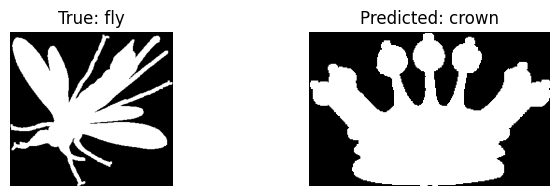

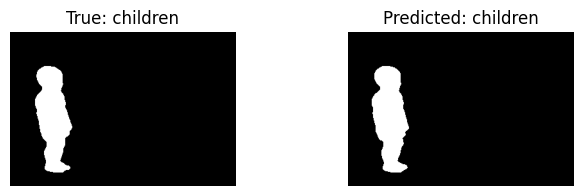

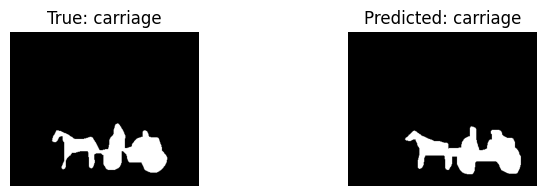

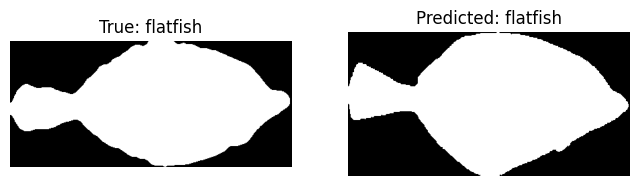

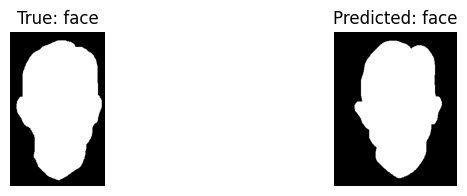

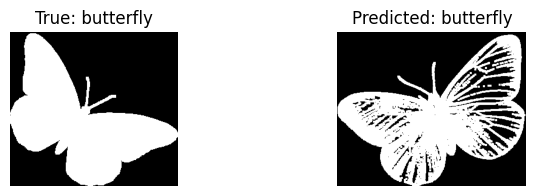

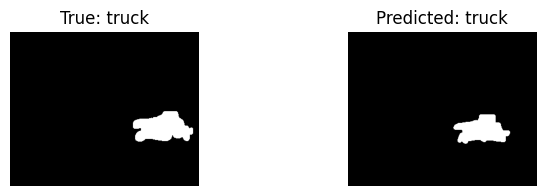

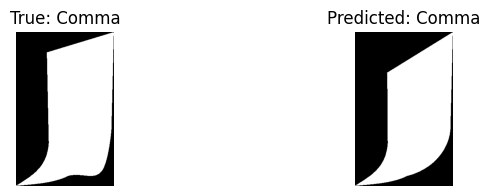

Accuracy with Manhattan: 76.71%

CHI-SQUARED DISTANCE


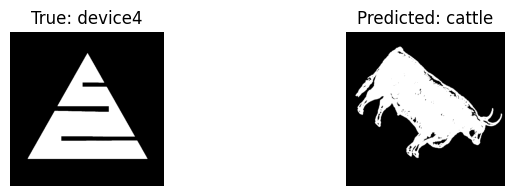

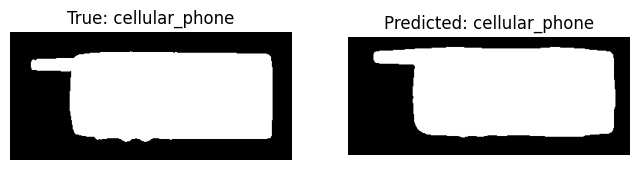

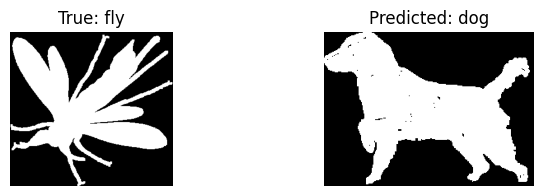

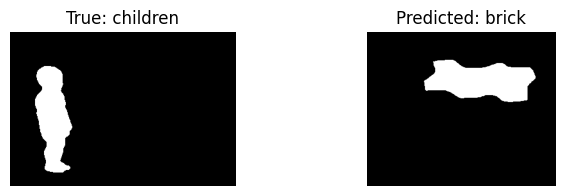

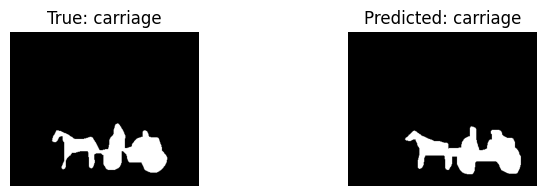

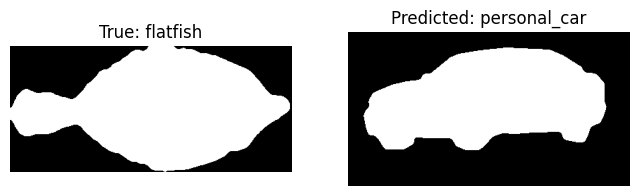

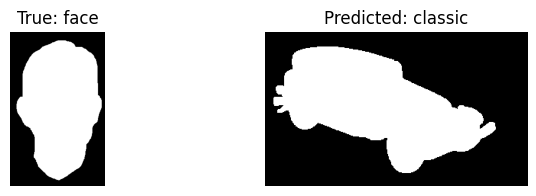

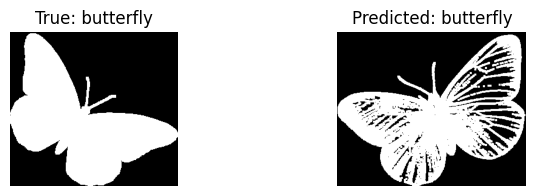

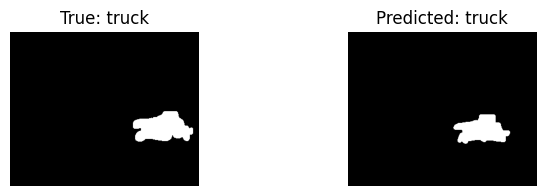

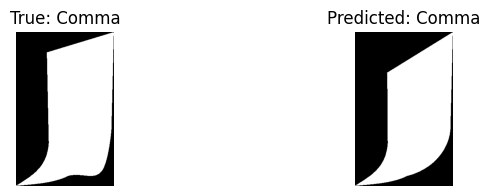

Accuracy with Chi-squared: 61.57%

MAHALANOBIS DISTANCE


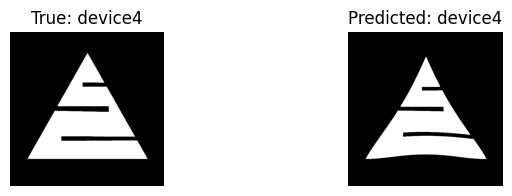

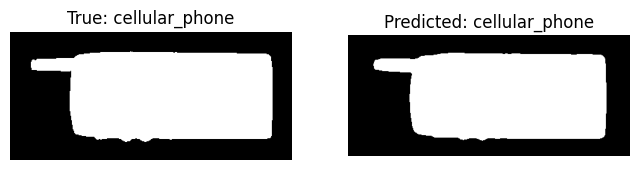

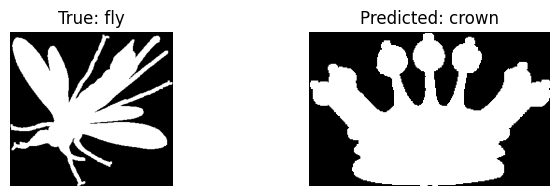

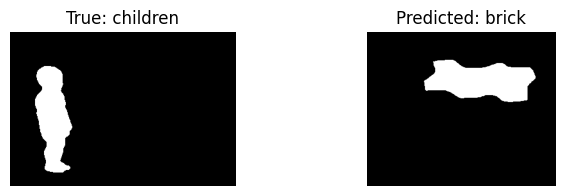

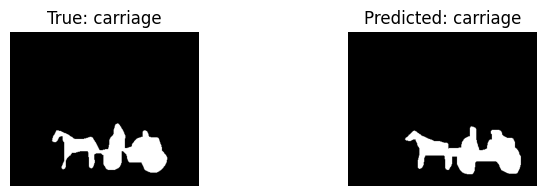

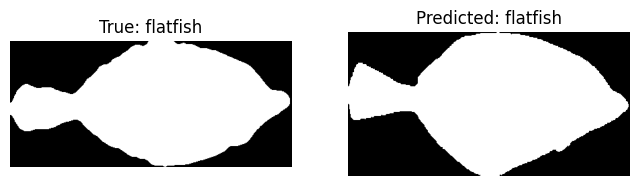

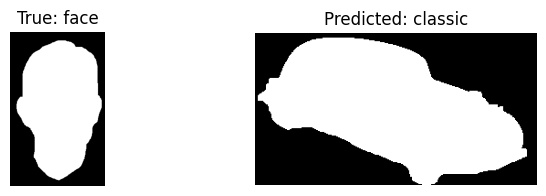

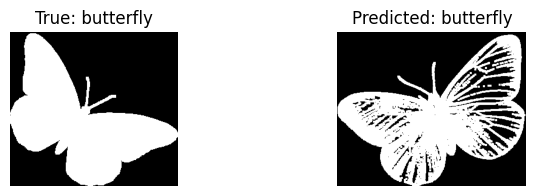

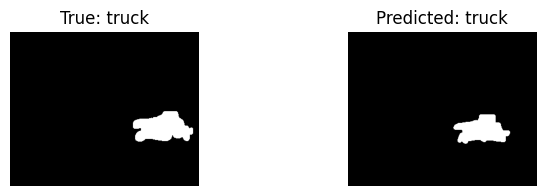

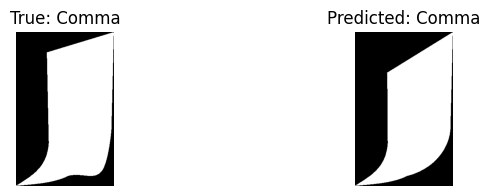

Accuracy with Mahalanobis: 70.86%





In [ ]:
accuracy_with_coefficient7 = run_experiments_for_fourier_coefficients(7)

Experiments with 9 Fourier coefficients:
EUCLIDEAN DISTANCE


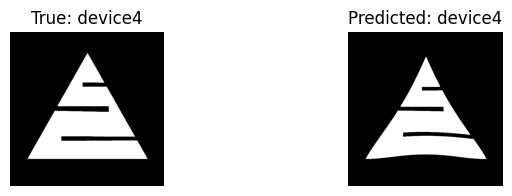

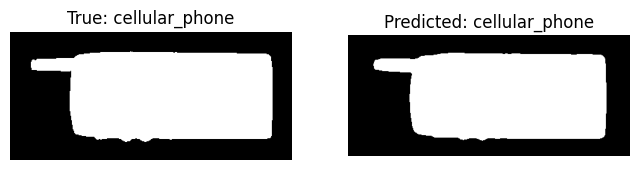

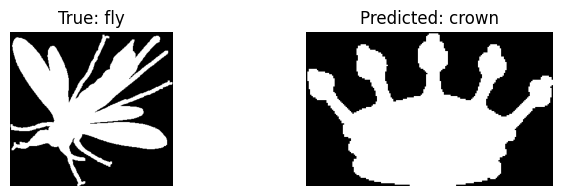

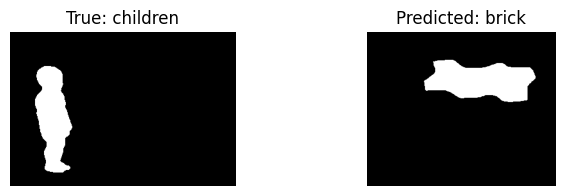

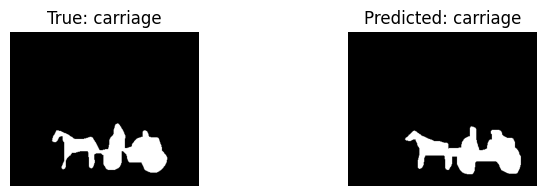

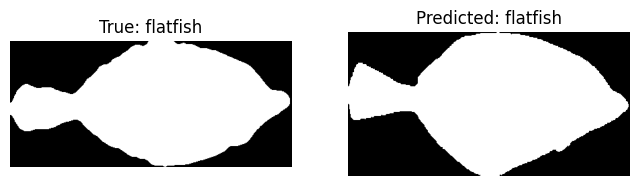

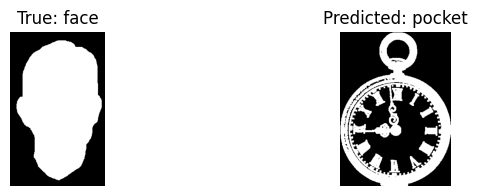

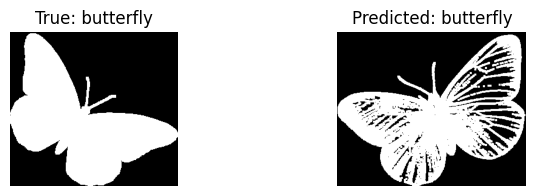

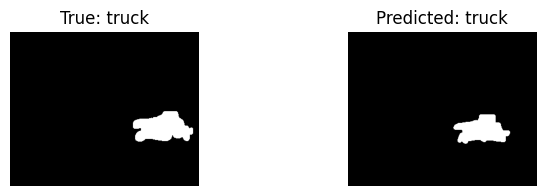

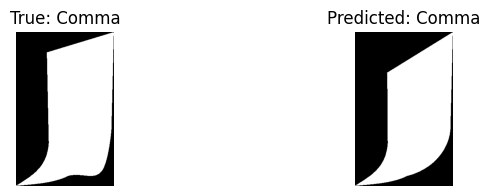

Accuracy with Euclidean: 69.29%

MANHATTAN DISTANCE


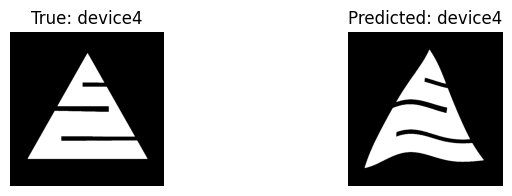

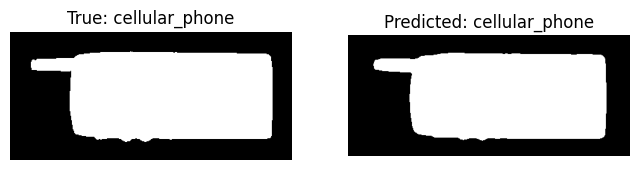

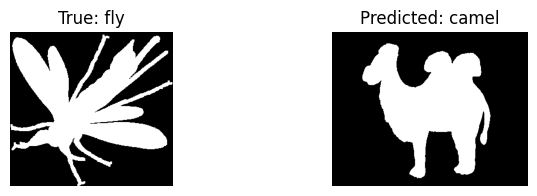

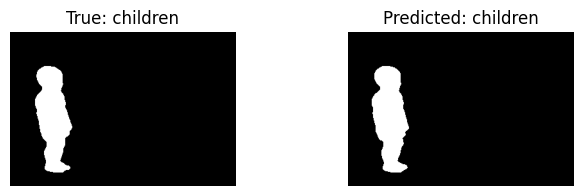

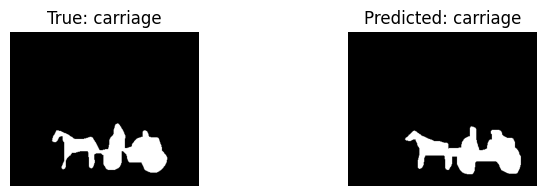

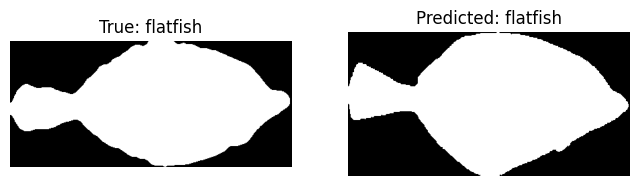

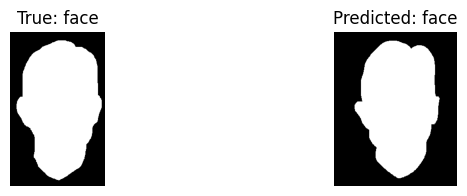

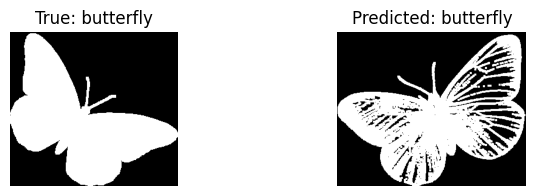

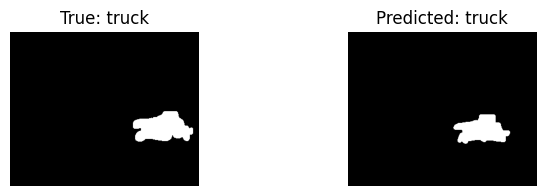

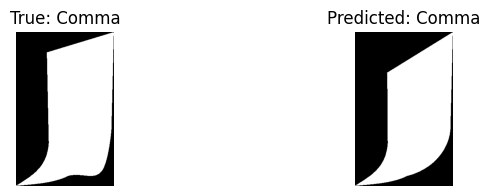

Accuracy with Manhattan: 77.00%

CHI-SQUARED DISTANCE


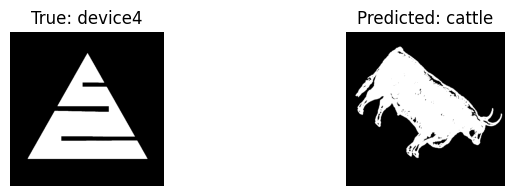

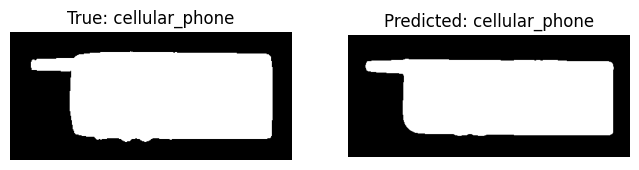

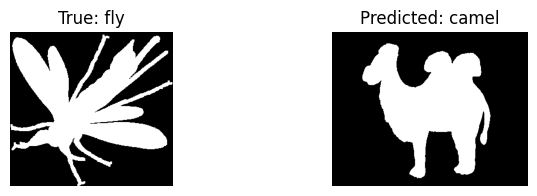

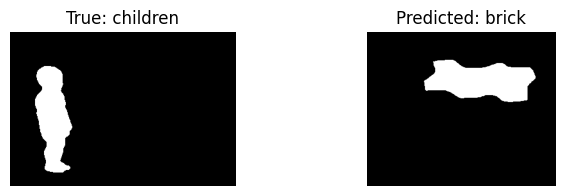

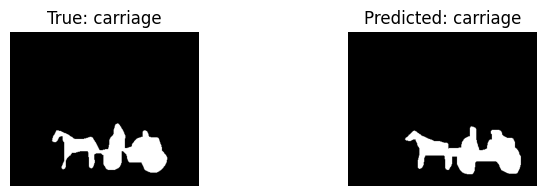

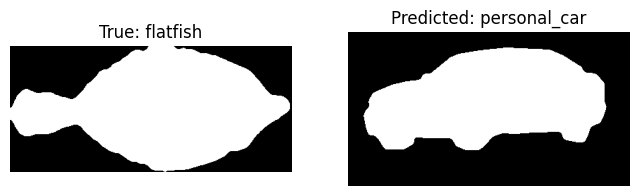

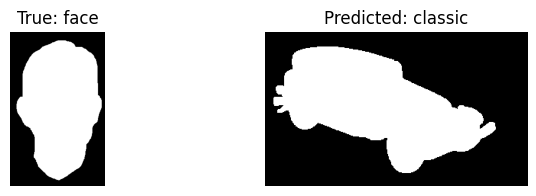

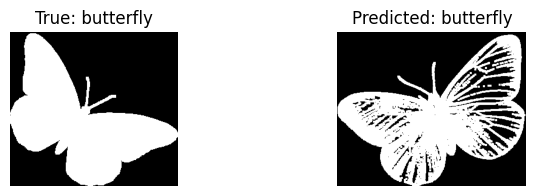

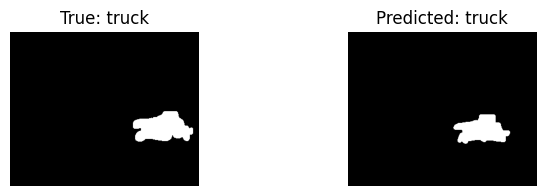

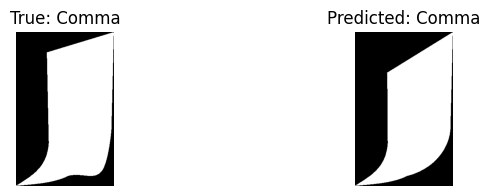

Accuracy with Chi-squared: 60.29%

MAHALANOBIS DISTANCE


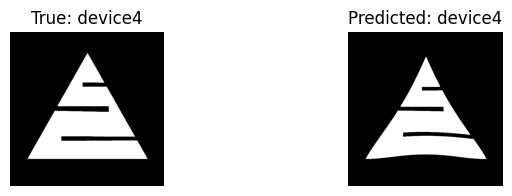

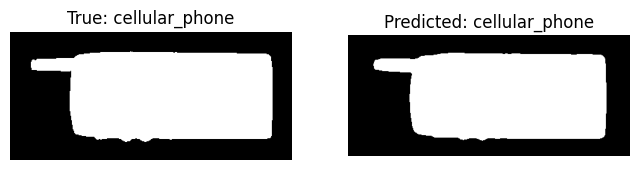

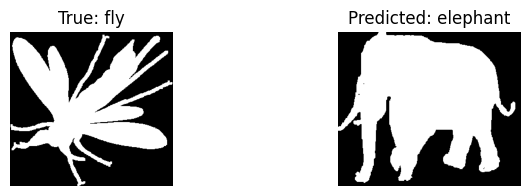

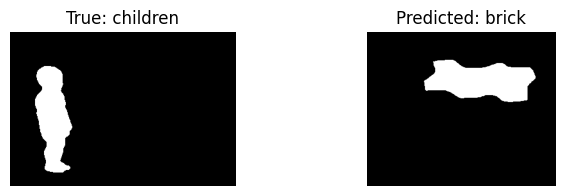

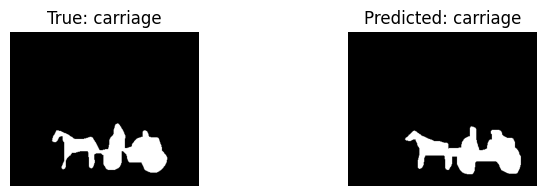

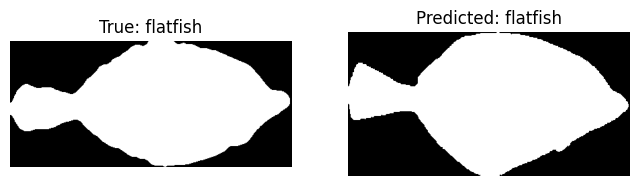

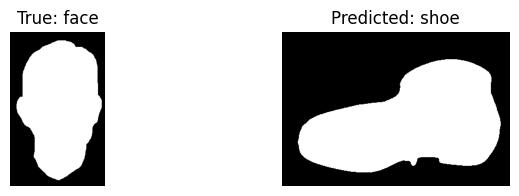

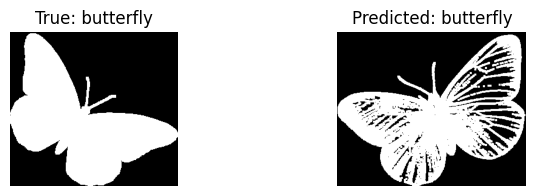

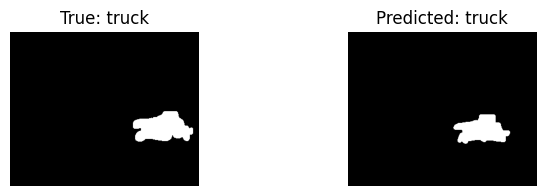

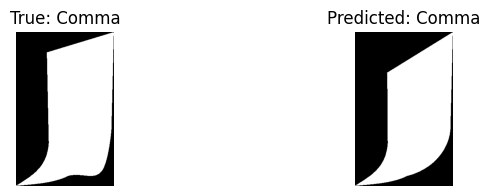

Accuracy with Mahalanobis: 70.43%





In [ ]:
accuracy_with_coefficient9 = run_experiments_for_fourier_coefficients(9)

In [ ]:
df3 = pd.DataFrame.from_dict(accuracy_with_coefficient3, orient='index')
df5 = pd.DataFrame.from_dict(accuracy_with_coefficient5, orient='index')
df7 = pd.DataFrame.from_dict(accuracy_with_coefficient7, orient='index')
df9 = pd.DataFrame.from_dict(accuracy_with_coefficient9, orient='index')

df = pd.concat([df3, df5, df7, df9]).reset_index()
df.rename(columns={'index': 'Number Of Coefficients'}, inplace=True)

for col in df.columns[1: ]:
    df[col] = df[col].apply( lambda x: f'{x * 100:.2f}%')

print(df)

,Number Of Coefficients,Euclidean,Manhattan,Chi-squared,Mahalanobis
0,3,65.00%,74.86%,60.14%,68.43%
1,5,67.14%,77.14%,62.00%,71.29%
2,7,69.29%,76.71%,61.57%,70.86%
3,9,69.29%,77.00%,60.29%,70.43%
